In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,ParameterGrid
import optuna.integration.lightgbm as lgb
from sklearn.model_selection import cross_val_score
import optuna
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import roc_auc_score

%matplotlib inline

In [2]:
import featuretools as ft

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

In [5]:
app_train = pd.read_csv('application_train.csv').sort_values('SK_ID_CURR').reset_index(drop = True).loc[:1000, :]
app_test = pd.read_csv('application_test.csv').sort_values('SK_ID_CURR').reset_index(drop = True).loc[:1000, :]
bureau_balance = pd.read_csv('bureau_balance.csv').sort_values('SK_ID_BUREAU').reset_index(drop = True).loc[:1000, :]
bureau = pd.read_csv('bureau.csv').sort_values(['SK_ID_CURR', 'SK_ID_BUREAU']).reset_index(drop = True).loc[:1000, :]
credit = pd.read_csv('credit_card_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:1000, :]
#HomeCredit_columns_description = pd.read_csv('HomeCredit_columns_description.csv')
installments =  pd.read_csv('installments_payments.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:1000, :]
cash = pd.read_csv('POS_CASH_balance.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:1000, :]
previous = pd.read_csv('previous_application.csv').sort_values(['SK_ID_CURR', 'SK_ID_PREV']).reset_index(drop = True).loc[:1000, :]

In [6]:
# Add identifying column
app_train['set'] = 'train'
app_test['set'] = 'test'
app_test["TARGET"] = np.nan

# Append the dataframes
app = app_train.append(app_test, ignore_index = True)

In [8]:
#Entity set with id applications
es = ft.EntitySet(id = 'clients')

In [19]:
#Entitiy with a unique index
es = es.add_dataframe(dataframe_name = 'app', dataframe = app, index = 'SK_ID_CURR')
es = es.add_dataframe(dataframe_name = 'bureau', dataframe = bureau, index = 'SK_ID_BUREAU')
es = es.add_dataframe(dataframe_name = 'previous', dataframe = previous, index = 'SK_ID_PREV')

#Entities that do not have a unique index
es = es.add_dataframe(dataframe_name = 'bureau_balance', dataframe = bureau_balance,make_index = True, index = 'bureaubalance_index')
es = es.add_dataframe(dataframe_name = 'cash', dataframe = cash,make_index = True, index = 'cash_index')
es = es.add_dataframe(dataframe_name = 'installments', dataframe = installments,make_index = True, index = 'installments_index')
es = es.add_dataframe(dataframe_name = 'credit', dataframe = credit, make_index = True, index = 'credit_index')





In [20]:
print('Parent: app, Parent Variable: SK_ID_CURR\n\n', app.iloc[:, 111:115].head())
print('\nChild: bureau, Child Variable: SK_ID_CURR\n\n', bureau.iloc[10:30, :4].head())

Parent: app, Parent Variable: SK_ID_CURR

         FLAG_DOCUMENT_17  FLAG_DOCUMENT_18  FLAG_DOCUMENT_19  FLAG_DOCUMENT_20
100002                 0                 0                 0                 0
100003                 0                 0                 0                 0
100004                 0                 0                 0                 0
100006                 0                 0                 0                 0
100007                 0                 0                 0                 0

Child: bureau, Child Variable: SK_ID_CURR

          SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY
6158905      100002       6158905        Closed      currency 1
6158906      100002       6158906        Closed      currency 1
6158907      100002       6158907        Closed      currency 1
6158908      100002       6158908        Closed      currency 1
6158909      100002       6158909        Active      currency 1


In [30]:
#Relationship between app and breau
r_app_bureau = es.add_relationship('app','SK_ID_CURR','bureau','SK_ID_CURR')

#Relationship between bureau and bureau balance
r_bureau_balance = es.add_relationship('bureau','SK_ID_BUREAU','bureau_balance','SK_ID_BUREAU')

# Relationship between current app and previous apps
r_app_previous = es.add_relationship('app','SK_ID_CURR','previous','SK_ID_CURR')

# Relationships between previous apps and cash, installments, and credit
r_previous_cash = es.add_relationship('previous','SK_ID_PREV','cash','SK_ID_PREV')
r_previous_installments = es.add_relationship('previous','SK_ID_PREV','installments','SK_ID_PREV')
r_previous_credit = es.add_relationship('previous','SK_ID_PREV','credit','SK_ID_PREV')



In [34]:
es

Entityset: clients
  DataFrames:
    app [Rows: 2002, Columns: 123]
    bureau [Rows: 1001, Columns: 17]
    previous [Rows: 1001, Columns: 37]
    bureau_balance [Rows: 1001, Columns: 4]
    cash [Rows: 1001, Columns: 9]
    installments [Rows: 1001, Columns: 9]
    credit [Rows: 1001, Columns: 24]
  Relationships:
    bureau.SK_ID_CURR -> app.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    previous.SK_ID_CURR -> app.SK_ID_CURR
    cash.SK_ID_PREV -> previous.SK_ID_PREV
    installments.SK_ID_PREV -> previous.SK_ID_PREV
    credit.SK_ID_PREV -> previous.SK_ID_PREV

In [35]:
# List the primitives in a dataframe
primitives = ft.list_primitives()
pd.options.display.max_colwidth = 100
primitives[primitives['type'] == 'aggregation']

name         type  dask_compatible  koalas_compatible  \
0     n_most_common  aggregation            False              False   
1               max  aggregation             True               True   
2  time_since_first  aggregation            False              False   
3               sum  aggregation             True               True   
4              mode  aggregation            False              False   
5               all  aggregation             True              False   
6              last  aggregation            False              False   
7      percent_true  aggregation             True              False   
8           entropy  aggregation            False              False   
9               std  aggregation             True               True   

                                                           description  \
0                             Determines the `n` most common elements.   
1                 Calculates the highest value, ignoring `NaN` values.   
2   Calculates the time elapsed since the first datetime (in seconds).   
3                       Calculates the total addition, ignoring `NaN`.   
4                         Determines the most commonly repeated value.   
5                       Calculates if all values are 'True' in a list.   
6                                 Determines the last value in a list.   
7                             Determines the percent of `True` values.   
8                      Calculates the entropy for a categorical column   
9  Computes the dispersion relative to the mean value, ignoring `NaN`.   

                                                                               valid_inputs  \
0                                             <ColumnSchema (Semantic Tags = ['category'])>   
1                                              <ColumnSchema (Semantic Tags = ['numeric'])>   
2                 <ColumnSchema (Logical Type = Datetime) (Semantic Tags = ['time_index'])>   
3                                              <ColumnSchema (Semantic Tags = ['numeric'])>   
4                                             <ColumnSchema (Semantic Tags = ['category'])>   
5  <ColumnSchema (Logical Type = BooleanNullable)>, <ColumnSchema (Logical Type = Boolean)>   
6                                                                            <ColumnSchema>   
7  <ColumnSchema (Logical Type = BooleanNullable)>, <ColumnSchema (Logical Type = Boolean)>   
8                                             <ColumnSchema (Semantic Tags = ['category'])>   
9                                              <ColumnSchema (Semantic Tags = ['numeric'])>   

  return_type  
0        None  
1        None  
2        None  
3        None  
4        None  
5        None  
6        None  
7        None  
8        None  
9        None

In [36]:
primitives[primitives['type'] == 'transform'].head(10)

name       type  dask_compatible  koalas_compatible  \
22       add_numeric_scalar  transform             True               True   
23                 cum_mean  transform            False              False   
24  email_address_to_domain  transform            False              False   
25               percentile  transform            False              False   
26               is_weekend  transform             True               True   
27                  cum_sum  transform            False              False   
28       less_than_equal_to  transform             True               True   
29                       or  transform             True               True   
30               url_to_tld  transform            False              False   
31        modulo_by_feature  transform             True               True   

                                                                 description  \
22                                   Add a scalar to each value in the list.   
23                                           Calculates the cumulative mean.   
24                                         Determines the domain of an email   
25                  Determines the percentile rank for each value in a list.   
26                                  Determines if a date falls on a weekend.   
27                                            Calculates the cumulative sum.   
28  Determines if values in one list are less than or equal to another list.   
29                                     Element-wise logical OR of two lists.   
30                                 Determines the top level domain of a url.   
31                Return the modulo of a scalar by each element in the list.   

                                                                                           valid_inputs  \
22                                                         <ColumnSchema (Semantic Tags = ['numeric'])>   
23                                                         <ColumnSchema (Semantic Tags = ['numeric'])>   
24                                                         <ColumnSchema (Logical Type = EmailAddress)>   
25                                                         <ColumnSchema (Semantic Tags = ['numeric'])>   
26                                                             <ColumnSchema (Logical Type = Datetime)>   
27                                                         <ColumnSchema (Semantic Tags = ['numeric'])>   
28  <ColumnSchema (Logical Type = Datetime)>, <ColumnSchema (Semantic Tags = ['numeric'])>, <ColumnS...   
29             <ColumnSchema (Logical Type = BooleanNullable)>, <ColumnSchema (Logical Type = Boolean)>   
30                                                                  <ColumnSchema (Logical Type = URL)>   
31                                                         <ColumnSchema (Semantic Tags = ['numeric'])>   

   return_type  
22        None  
23        None  
24        None  
25        None  
26        None  
27        None  
28        None  
29        None  
30        None  
31        None

In [44]:
# Default primitives from featuretools
default_agg_primitives =  ["sum", "std", "max", "skew", "min", "mean", "count", "percent_true", "num_unique", "mode"]
default_trans_primitives =  ["day", "year", "month", "weekday", "haversine"]

# DFS with specified primitives
feature_names = ft.dfs(entityset = es, target_dataframe_name='app',
                       trans_primitives = default_trans_primitives,
                       agg_primitives= default_agg_primitives, 
                       max_depth = 2, features_only=True)

print('%d Total Features' % len(feature_names))


2213 Total Features


In [48]:
feature_matrix,feature_names = ft.dfs(entityset = es, target_dataframe_name = 'app',
                                       trans_primitives = default_trans_primitives,
                                       agg_primitives=default_agg_primitives, 
                                        max_depth = 2, features_only=False, verbose = True)

pd.options.display.max_columns = 1700
feature_matrix.head(10)                                        

Built 2213 features
Elapsed: 00:14 | Progress: 100%|██████████


TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
100002         1.0         Cash loans           M            N   
100003         0.0         Cash loans           F            N   
100004         0.0    Revolving loans           M            Y   
100006         0.0         Cash loans           F            N   
100007         0.0         Cash loans           M            N   
100008         0.0         Cash loans           M            N   
100009         0.0         Cash loans           F            Y   
100010         0.0         Cash loans           M            Y   
100011         0.0         Cash loans           F            N   
100012         0.0    Revolving loans           M            N   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
100002                   Y             0          202500.0    406597.5   
100003                   N             0          270000.0   1293502.5   
100004                   Y             0           67500.0    135000.0   
100006                   Y             0          135000.0    312682.5   
100007                   Y             0          121500.0    513000.0   
100008                   Y             0           99000.0    490495.5   
100009                   Y             1          171000.0   1560726.0   
100010                   Y             0          360000.0   1530000.0   
100011                   Y             0          112500.0   1019610.0   
100012                   Y             0          135000.0    405000.0   

            AMT_ANNUITY  AMT_GOODS_PRICE  NAME_TYPE_SUITE  \
SK_ID_CURR                                                  
100002          24700.5         351000.0    Unaccompanied   
100003          35698.5        1129500.0           Family   
100004           6750.0         135000.0    Unaccompanied   
100006          29686.5         297000.0    Unaccompanied   
100007          21865.5         513000.0    Unaccompanied   
100008          27517.5         454500.0  Spouse, partner   
100009          41301.0        1395000.0    Unaccompanied   
100010          42075.0        1530000.0    Unaccompanied   
100011          33826.5         913500.0         Children   
100012          20250.0         405000.0    Unaccompanied   

                NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
SK_ID_CURR                                                        
100002                   Working  Secondary / secondary special   
100003             State servant               Higher education   
100004                   Working  Secondary / secondary special   
100006                   Working  Secondary / secondary special   
100007                   Working  Secondary / secondary special   
100008             State servant  Secondary / secondary special   
100009      Commercial associate               Higher education   
100010             State servant               Higher education   
100011                 Pensioner  Secondary / secondary special   
100012                   Working  Secondary / secondary special   

              NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
SK_ID_CURR                                            
100002      Single / not married  House / apartment   
100003                   Married  House / apartment   
100004      Single / not married  House / apartment   
100006            Civil marriage  House / apartment   
100007      Single / not married  House / apartment   
100008                   Married  House / apartment   
100009                   Married  House / apartment   
100010                   Married  House / apartment   
100011                   Married  House / apartment   
100012      Single / not married  House / apartment   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                    

In [49]:
feature_names[-20:]

[<Feature: STD(credit.previous.SELLERPLACE_AREA)>,
 <Feature: SUM(credit.previous.AMT_ANNUITY)>,
 <Feature: SUM(credit.previous.AMT_APPLICATION)>,
 <Feature: SUM(credit.previous.AMT_CREDIT)>,
 <Feature: SUM(credit.previous.AMT_DOWN_PAYMENT)>,
 <Feature: SUM(credit.previous.AMT_GOODS_PRICE)>,
 <Feature: SUM(credit.previous.CNT_PAYMENT)>,
 <Feature: SUM(credit.previous.DAYS_DECISION)>,
 <Feature: SUM(credit.previous.DAYS_FIRST_DRAWING)>,
 <Feature: SUM(credit.previous.DAYS_FIRST_DUE)>,
 <Feature: SUM(credit.previous.DAYS_LAST_DUE)>,
 <Feature: SUM(credit.previous.DAYS_LAST_DUE_1ST_VERSION)>,
 <Feature: SUM(credit.previous.DAYS_TERMINATION)>,
 <Feature: SUM(credit.previous.HOUR_APPR_PROCESS_START)>,
 <Feature: SUM(credit.previous.NFLAG_INSURED_ON_APPROVAL)>,
 <Feature: SUM(credit.previous.NFLAG_LAST_APPL_IN_DAY)>,
 <Feature: SUM(credit.previous.RATE_DOWN_PAYMENT)>,
 <Feature: SUM(credit.previous.RATE_INTEREST_PRIMARY)>,
 <Feature: SUM(credit.previous.RATE_INTEREST_PRIVILEGED)>,
 <Feature:

In [51]:
#Specifiy the aggregation primitives
feature_matrix_spec, feature_names_spec = ft.dfs(entityset = es, target_dataframe_name = 'app',  
                                                 agg_primitives = ['sum', 'count', 'min', 'max', 'mean', 'mode'], 
                                                 max_depth = 2, features_only = False, verbose = True)

Built 1211 features
Elapsed: 00:05 | Progress: 100%|██████████


In [52]:
pd.options.display.max_columns = 1000
feature_matrix_spec.head(10)

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
100002         1.0         Cash loans           M            N   
100003         0.0         Cash loans           F            N   
100004         0.0    Revolving loans           M            Y   
100006         0.0         Cash loans           F            N   
100007         0.0         Cash loans           M            N   
100008         0.0         Cash loans           M            N   
100009         0.0         Cash loans           F            Y   
100010         0.0         Cash loans           M            Y   
100011         0.0         Cash loans           F            N   
100012         0.0    Revolving loans           M            N   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
100002                   Y             0          202500.0    406597.5   
100003                   N             0          270000.0   1293502.5   
100004                   Y             0           67500.0    135000.0   
100006                   Y             0          135000.0    312682.5   
100007                   Y             0          121500.0    513000.0   
100008                   Y             0           99000.0    490495.5   
100009                   Y             1          171000.0   1560726.0   
100010                   Y             0          360000.0   1530000.0   
100011                   Y             0          112500.0   1019610.0   
100012                   Y             0          135000.0    405000.0   

            AMT_ANNUITY  AMT_GOODS_PRICE  NAME_TYPE_SUITE  \
SK_ID_CURR                                                  
100002          24700.5         351000.0    Unaccompanied   
100003          35698.5        1129500.0           Family   
100004           6750.0         135000.0    Unaccompanied   
100006          29686.5         297000.0    Unaccompanied   
100007          21865.5         513000.0    Unaccompanied   
100008          27517.5         454500.0  Spouse, partner   
100009          41301.0        1395000.0    Unaccompanied   
100010          42075.0        1530000.0    Unaccompanied   
100011          33826.5         913500.0         Children   
100012          20250.0         405000.0    Unaccompanied   

                NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
SK_ID_CURR                                                        
100002                   Working  Secondary / secondary special   
100003             State servant               Higher education   
100004                   Working  Secondary / secondary special   
100006                   Working  Secondary / secondary special   
100007                   Working  Secondary / secondary special   
100008             State servant  Secondary / secondary special   
100009      Commercial associate               Higher education   
100010             State servant               Higher education   
100011                 Pensioner  Secondary / secondary special   
100012                   Working  Secondary / secondary special   

              NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
SK_ID_CURR                                            
100002      Single / not married  House / apartment   
100003                   Married  House / apartment   
100004      Single / not married  House / apartment   
100006            Civil marriage  House / apartment   
100007      Single / not married  House / apartment   
100008                   Married  House / apartment   
100009                   Married  House / apartment   
100010                   Married  House / apartment   
100011                   Married  House / apartment   
100012      Single / not married  House / apartment   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                    

In [55]:
correlations = pd.DataFrame(feature_matrix_spec.corr())
correlations.index.name = 'Variable'
correlations.head()

TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
Variable                                                                 
TARGET            1.000000      0.025307         -0.007118    0.008316   
CNT_CHILDREN      0.025307      1.000000          0.045813    0.002410   
AMT_INCOME_TOTAL -0.007118      0.045813          1.000000    0.413117   
AMT_CREDIT        0.008316      0.002410          0.413117    1.000000   
AMT_ANNUITY       0.024608      0.023826          0.486044    0.771190   

                  AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
Variable                                                                     
TARGET               0.024608        -0.001968                    0.014177   
CNT_CHILDREN         0.023826        -0.001697                   -0.029300   
AMT_INCOME_TOTAL     0.486044         0.418351                    0.209621   
AMT_CREDIT           0.771190         0.986906                    0.101144   
AMT_ANNUITY          1.000000         0.773800                    0.116639   

                  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
Variable                                                         
TARGET              0.082907      -0.010218           0.017294   
CNT_CHILDREN        0.307422      -0.238034           0.181558   
AMT_INCOME_TOTAL    0.070745      -0.197548           0.083315   
AMT_CREDIT         -0.061776      -0.112875           0.021207   
AMT_ANNUITY         0.034653      -0.152037           0.055317   

                  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  \
Variable                                                                     
TARGET                   0.055585    -0.042166         NaN        0.011991   
CNT_CHILDREN            -0.029758     0.073046         NaN        0.239114   
AMT_INCOME_TOTAL         0.047704    -0.197711         NaN        0.196764   
AMT_CREDIT               0.000342    -0.115455         NaN        0.111235   
AMT_ANNUITY              0.017764    -0.121954         NaN        0.151380   

                  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
Variable                                                                      
TARGET                   0.049613          0.015034   -0.015172   -0.007614   
CNT_CHILDREN             0.018667          0.010599   -0.052892    0.067123   
AMT_INCOME_TOTAL        -0.042697          0.019151    0.014203    0.100260   
AMT_CREDIT              -0.065063          0.047616    0.024988    0.035303   
AMT_ANNUITY             -0.086996          0.060842    0.006076    0.087160   

                  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
Variable                                                  
TARGET                  -0.004360              0.048279   
CNT_CHILDREN             0.885509              0.009566   
AMT_INCOME_TOTAL         0.053982             -0.239570   
AMT_CREDIT               0.072313             -0.101845   
AMT_ANNUITY              0.086728             -0.131282   

                  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
Variable                                                                 
TARGET                               0.047879                -0.047849   
CNT_CHILDREN                         0.020860                -0.045242   
AMT_INCOME_TOTAL                    -0.250599                 0.049676   
AMT_CREDIT                          -0.110144                 0.036429   
AMT_ANNUITY                         -0.131239                 0.018041   

                  REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
Variable                                                                   
TARGET                              0.051329                    0.034044   
CNT_CHILDREN                       -0.000808                    0.021506   
AMT_INCOME_TOTAL                    0.085630                    0.182124   
AMT_CREDIT                          0.001710                    0.044024   
A

In [59]:
correlations_target = pd.DataFrame(correlations.sort_values('TARGET')['TARGET'])
correlations_target


TARGET
Variable                                                
MIN(previous.MAX(credit.MONTHS_BALANCE))       -0.363774
MEAN(previous.MAX(credit.MONTHS_BALANCE))      -0.363774
MAX(credit.MONTHS_BALANCE)                     -0.363774
MIN(previous.MAX(installments.SK_ID_CURR))     -0.349691
MIN(previous.MEAN(installments.SK_ID_CURR))    -0.349691
...                                                  ...
SUM(credit.previous.CNT_PAYMENT)                     NaN
SUM(credit.previous.NFLAG_INSURED_ON_APPROVAL)       NaN
SUM(credit.previous.RATE_DOWN_PAYMENT)               NaN
SUM(credit.previous.RATE_INTEREST_PRIMARY)           NaN
SUM(credit.previous.RATE_INTEREST_PRIVILEGED)        NaN

[1118 rows x 1 columns]

In [60]:
correlations_target.dropna().tail()

TARGET
Variable                                               
MIN(previous.MAX(cash.CNT_INSTALMENT_FUTURE))  0.643478
MIN(cash.previous.CNT_PAYMENT)                 0.649665
MIN(previous.MEAN(cash.CNT_INSTALMENT))        0.649785
MIN(installments.previous.CNT_PAYMENT)         0.660703
TARGET                                         1.000000

In [62]:
feature_matrix

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
100002         1.0         Cash loans           M            N   
100003         0.0         Cash loans           F            N   
100004         0.0    Revolving loans           M            Y   
100006         0.0         Cash loans           F            N   
100007         0.0         Cash loans           M            N   
...            ...                ...         ...          ...   
106852         NaN         Cash loans           M            N   
106853         NaN         Cash loans           M            Y   
106854         NaN         Cash loans           F            N   
106861         NaN         Cash loans           F            N   
106873         NaN         Cash loans           M            N   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
100002                   Y             0          202500.0    406597.5   
100003                   N             0          270000.0   1293502.5   
100004                   Y             0           67500.0    135000.0   
100006                   Y             0          135000.0    312682.5   
100007                   Y             0          121500.0    513000.0   
...                    ...           ...               ...         ...   
106852                   Y             2          225000.0    177768.0   
106853                   N             0          202500.0    479700.0   
106854                   Y             0          202500.0    574402.5   
106861                   N             0          112500.0    677664.0   
106873                   Y             1          157500.0    199152.0   

            AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE  \
SK_ID_CURR                                                 
100002          24700.5         351000.0   Unaccompanied   
100003          35698.5        1129500.0          Family   
100004           6750.0         135000.0   Unaccompanied   
100006          29686.5         297000.0   Unaccompanied   
100007          21865.5         513000.0   Unaccompanied   
...                 ...              ...             ...   
106852          14175.0         135000.0             NaN   
106853          49153.5         450000.0   Unaccompanied   
106854          29457.0         495859.5   Unaccompanied   
106861          29979.0         585000.0   Unaccompanied   
106873          10800.0         135000.0   Unaccompanied   

                NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
SK_ID_CURR                                                        
100002                   Working  Secondary / secondary special   
100003             State servant               Higher education   
100004                   Working  Secondary / secondary special   
100006                   Working  Secondary / secondary special   
100007                   Working  Secondary / secondary special   
...                          ...                            ...   
106852             State servant               Higher education   
106853      Commercial associate  Secondary / secondary special   
106854                   Working  Secondary / secondary special   
106861                   Working  Secondary / secondary special   
106873                   Working  Secondary / secondary special   

              NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
SK_ID_CURR                                            
100002      Single / not married  House / apartment   
100003                   Married  House / apartment   
100004      Single / not married  House / apartment   
100006            Civil marriage  House / apartment   
100007      Single / not married  House / apartment   
...                          ...                ...   
106852                   Married  House / apartment   
106853      Single / not married   Rented 

In [64]:
features_sample = feature_matrix[feature_matrix['set'] == 'train']
features_sample

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
SK_ID_CURR                                                       
100002         1.0         Cash loans           M            N   
100003         0.0         Cash loans           F            N   
100004         0.0    Revolving loans           M            Y   
100006         0.0         Cash loans           F            N   
100007         0.0         Cash loans           M            N   
...            ...                ...         ...          ...   
101153         0.0         Cash loans           F            N   
101154         0.0         Cash loans           F            Y   
101155         0.0         Cash loans           M            N   
101156         0.0         Cash loans           M            Y   
101157         0.0         Cash loans           F            Y   

           FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
SK_ID_CURR                                                               
100002                   Y             0          202500.0    406597.5   
100003                   N             0          270000.0   1293502.5   
100004                   Y             0           67500.0    135000.0   
100006                   Y             0          135000.0    312682.5   
100007                   Y             0          121500.0    513000.0   
...                    ...           ...               ...         ...   
101153                   Y             0          225000.0   1113840.0   
101154                   Y             0          144000.0    517536.0   
101155                   Y             0          315000.0   1288350.0   
101156                   Y             2          180000.0    679500.0   
101157                   Y             0          135000.0    679500.0   

            AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE  \
SK_ID_CURR                                                 
100002          24700.5         351000.0   Unaccompanied   
100003          35698.5        1129500.0          Family   
100004           6750.0         135000.0   Unaccompanied   
100006          29686.5         297000.0   Unaccompanied   
100007          21865.5         513000.0   Unaccompanied   
...                 ...              ...             ...   
101153          57001.5         900000.0   Unaccompanied   
101154          28206.0         432000.0   Unaccompanied   
101155          37800.0        1125000.0   Unaccompanied   
101156          27076.5         679500.0   Unaccompanied   
101157          22585.5         679500.0          Family   

                NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
SK_ID_CURR                                                        
100002                   Working  Secondary / secondary special   
100003             State servant               Higher education   
100004                   Working  Secondary / secondary special   
100006                   Working  Secondary / secondary special   
100007                   Working  Secondary / secondary special   
...                          ...                            ...   
101153      Commercial associate  Secondary / secondary special   
101154                 Pensioner  Secondary / secondary special   
101155      Commercial associate               Higher education   
101156                   Working  Secondary / secondary special   
101157                 Pensioner  Secondary / secondary special   

              NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
SK_ID_CURR                                            
100002      Single / not married  House / apartment   
100003                   Married  House / apartment   
100004      Single / not married  House / apartment   
100006            Civil marriage  House / apartment   
100007      Single / not married  House / apartment   
...                          ...                ...   
101153      Single / not married  House / apartment   
101154                   Married  House / 

In [67]:
def kde_target_plot(df, feature):
    
    # Need to reset index for loc to workBU
    df = df.reset_index()
    plt.figure(figsize = (10, 6))
    plt.style.use('fivethirtyeight')
    
    # plot repaid loans
    sns.kdeplot(df.loc[df['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df.loc[df['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of Feature by Target Value')
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    plt.show()

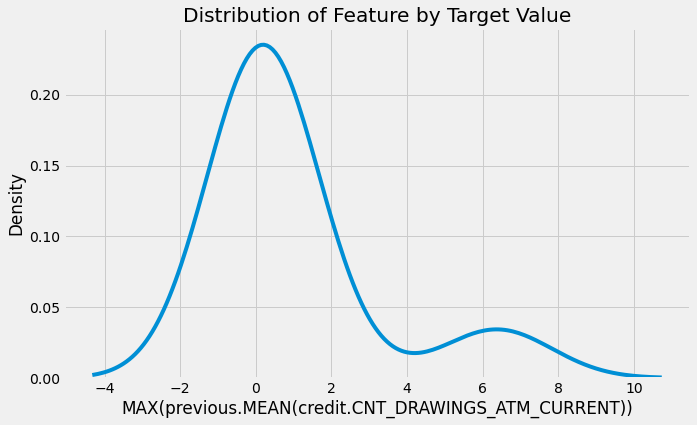

In [72]:
kde_target_plot(features_sample, feature = 'MAX(previous.MEAN(credit.CNT_DRAWINGS_ATM_CURRENT))')

In [73]:
threshold = 0.9

correlated_pairs = {}

# Iterate through the columns
for col in correlations:
    # Find correlations above the threshold
    above_threshold_vars = [x for x in list(correlations.index[correlations[col] > threshold]) if x != col]
    correlated_pairs[col] = above_threshold_vars

In [74]:
correlated_pairs['MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT)']

['MEAN(cash.CNT_INSTALMENT)',
 'MAX(installments.NUM_INSTALMENT_NUMBER)',
 'MEAN(installments.NUM_INSTALMENT_NUMBER)',
 'MEAN(credit.AMT_DRAWINGS_CURRENT)',
 'MEAN(credit.AMT_PAYMENT_CURRENT)',
 'MAX(previous.MEAN(credit.AMT_DRAWINGS_CURRENT))',
 'MAX(previous.MEAN(credit.AMT_PAYMENT_CURRENT))',
 'MAX(previous.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))',
 'MAX(previous.MEAN(installments.NUM_INSTALMENT_NUMBER))',
 'MAX(previous.MIN(cash.CNT_INSTALMENT))',
 'MEAN(previous.MAX(installments.NUM_INSTALMENT_NUMBER))',
 'MEAN(previous.MEAN(credit.AMT_DRAWINGS_CURRENT))',
 'MEAN(previous.MEAN(credit.AMT_PAYMENT_CURRENT))',
 'MEAN(previous.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))',
 'MEAN(previous.MEAN(installments.NUM_INSTALMENT_NUMBER))',
 'MIN(previous.MEAN(credit.AMT_DRAWINGS_CURRENT))',
 'MIN(previous.MEAN(credit.AMT_PAYMENT_CURRENT))',
 'MIN(previous.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))',
 'SUM(previous.MEAN(credit.AMT_DRAWINGS_CURRENT))',
 'SUM(previous.MEAN(credit.AMT_PAYMENT_CURRENT))',

In [78]:
correlations['MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT)'].sort_values(ascending=False).head()

Variable
SUM(previous.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))     1.0
MEAN(previous.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))    1.0
MIN(previous.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))     1.0
MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT)                   1.0
MAX(previous.MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT))     1.0
Name: MEAN(credit.AMT_PAYMENT_TOTAL_CURRENT), dtype: float64

In [79]:
from featuretools import selection

# Remove features with only one unique value
feature_matrix2 = selection.remove_low_information_features(feature_matrix)

print('Removed %d features' % (feature_matrix.shape[1]- feature_matrix2.shape[1]))

Removed 369 features


In [80]:
# Separate out the train and test sets
train = feature_matrix2[feature_matrix2['set'] == 'train']
test = feature_matrix2[feature_matrix2['set'] == 'test']

# One hot encoding
train = pd.get_dummies(train)
test = pd.get_dummies(test)

# Align dataframes on the columns
train, test = train.align(test, join = 'inner', axis = 1)
test = test.drop(columns = ['TARGET'])

print('Final Training Shape: ', train.shape)
print('Final Testing Shape: ', test.shape)

Final Training Shape:  (1001, 2156)
Final Testing Shape:  (1001, 2155)


In [88]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1001 entries, 100002 to 101157
Columns: 2156 entries, TARGET to MODE(credit.previous.WEEKDAY_APPR_PROCESS_START)_WEDNESDAY
dtypes: Int64(77), float64(1650), int64(29), uint8(400)
memory usage: 13.9 MB


In [89]:
train

TARGET  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                                    
100002         1.0             0          202500.0    406597.5      24700.5   
100003         0.0             0          270000.0   1293502.5      35698.5   
100004         0.0             0           67500.0    135000.0       6750.0   
100006         0.0             0          135000.0    312682.5      29686.5   
100007         0.0             0          121500.0    513000.0      21865.5   
...            ...           ...               ...         ...          ...   
101153         0.0             0          225000.0   1113840.0      57001.5   
101154         0.0             0          144000.0    517536.0      28206.0   
101155         0.0             0          315000.0   1288350.0      37800.0   
101156         0.0             2          180000.0    679500.0      27076.5   
101157         0.0             0          135000.0    679500.0      22585.5   

            AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
SK_ID_CURR                                                            
100002             351000.0                    0.018801       -9461   
100003            1129500.0                    0.003541      -16765   
100004             135000.0                    0.010032      -19046   
100006             297000.0                    0.008019      -19005   
100007             513000.0                    0.028663      -19932   
...                     ...                         ...         ...   
101153             900000.0                    0.046220      -14075   
101154             432000.0                    0.007020      -21027   
101155            1125000.0                    0.024610      -16204   
101156             679500.0                    0.028663      -17530   
101157             679500.0                    0.015221      -23218   

            DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
SK_ID_CURR                                                                   
100002               -637            -3648.0            -2120          NaN   
100003              -1188            -1186.0             -291          NaN   
100004               -225            -4260.0            -2531         26.0   
100006              -3039            -9833.0            -2437          NaN   
100007              -3038            -4311.0            -3458          NaN   
...                   ...                ...              ...          ...   
101153               -901            -8049.0            -4181          NaN   
101154             365243           -12357.0            -4466          2.0   
101155              -1461            -1046.0            -1216          NaN   
101156               -695              -92.0            -1066          9.0   
101157             365243             -696.0            -4755          1.0   

            FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
SK_ID_CURR                                                                  
100002                   1                0                 1           1   
100003                   1                0                 1           1   
100004                   1                1                 1           1   
100006                   1                0                 1           0   
100007                   1                0                 1           0   
...                    ...              ...               ...         ...   
101153                   1                0                 1           0   
101154                   0                0                 1           0   
101155                   1                1                 1           0   
101156                   1                1                 1           1   
101157                   0                0                 1           0   

            FLAG_EMAIL  CNT_FAM_MEMBERS  RE

In [93]:
X = train.drop(columns=['TARGET'])
d = X.dropna(axis=1)
y = train['TARGET']
d

CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
SK_ID_CURR                                                            
100002                 0          202500.0    406597.5      24700.5   
100003                 0          270000.0   1293502.5      35698.5   
100004                 0           67500.0    135000.0       6750.0   
100006                 0          135000.0    312682.5      29686.5   
100007                 0          121500.0    513000.0      21865.5   
...                  ...               ...         ...          ...   
101153                 0          225000.0   1113840.0      57001.5   
101154                 0          144000.0    517536.0      28206.0   
101155                 0          315000.0   1288350.0      37800.0   
101156                 2          180000.0    679500.0      27076.5   
101157                 0          135000.0    679500.0      22585.5   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
100002                        0.018801       -9461           -637   
100003                        0.003541      -16765          -1188   
100004                        0.010032      -19046           -225   
100006                        0.008019      -19005          -3039   
100007                        0.028663      -19932          -3038   
...                                ...         ...            ...   
101153                        0.046220      -14075           -901   
101154                        0.007020      -21027         365243   
101155                        0.024610      -16204          -1461   
101156                        0.028663      -17530           -695   
101157                        0.015221      -23218         365243   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_EMP_PHONE  \
SK_ID_CURR                                                       
100002                -3648.0            -2120               1   
100003                -1186.0             -291               1   
100004                -4260.0            -2531               1   
100006                -9833.0            -2437               1   
100007                -4311.0            -3458               1   
...                       ...              ...             ...   
101153                -8049.0            -4181               1   
101154               -12357.0            -4466               0   
101155                -1046.0            -1216               1   
101156                  -92.0            -1066               1   
101157                 -696.0            -4755               0   

            FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
SK_ID_CURR                                                              
100002                    0                 1           1           0   
100003                    0                 1           1           0   
100004                    1                 1           1           0   
100006                    0                 1           0           0   
100007                    0                 1           0           0   
...                     ...               ...         ...         ...   
101153                    0                 1           0           0   
101154                    0                 1           0           0   
101155                    1                 1           0           0   
101156                    1                 1           1           0   
101157                    0                 1           0           0   

            CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
SK_ID_CURR                                          
100002                  1.0                     2   
100003                  2.0                     1   
100004                  1.0                     2   
100006                  2.0                     2   
100007                  1.0                     2   
...       

In [101]:
X_train,X_test,y_train,y_test = train_test_split(d,y)

lgb_train = lgb.Dataset(X_train,y_train)
lgb_eval = lgb.Dataset(X_test,y_test,reference=lgb_train)

In [102]:
params = {
    # 二値分類問題
    'objective': 'binary',
    # AUC の最大化を目指す
    'metric': 'auc',
    # Fatal の場合出力
    'verbosity': -1,
}

In [103]:
model = lgb.train(params, lgb_train, valid_sets=lgb_eval,
                  verbose_eval=50,  # 50イテレーション毎に学習結果出力
                  num_boost_round=1000,  # 最大イテレーション回数指定
                  early_stopping_rounds=100
                 )

[I 2022-01-03 17:17:04,033] A new study created in memory with name: no-name-1dc5f681-3faf-4039-8990-b2a5674e1363
feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s][W 2022-01-03 17:17:04,066] Trial 0 failed because of the following error: ValueError('DataFrame.dtypes for data must be int, float or bool.\nDid not expect the data types in the following fields: COUNT(bureau), COUNT(previous), COUNT(cash), COUNT(installments), COUNT(credit)')
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "/opt/anaconda3/lib/python3.8/site-packages/optuna/integration/_lightgbm_tuner/optimize.py", line 249, in __call__
    booster = lgb.train(self.lgbm_params, train_set, **kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/lightgbm/engine.py", line 271, in train
    booster = Booster(params=params, train_set=train_set)
  File "/opt/anaconda3/lib/py

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: COUNT(bureau), COUNT(previous), COUNT(cash), COUNT(installments), COUNT(credit)